# [R990] Genarate data with $F$ vector $F$ vector for n poles and n channels 
## Working plots Remco

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Iterable, Mapping

import ampform
import attrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qrules
import sympy as sp
from ampform.dynamics.builder import TwoBodyKinematicVariableSet
from ampform.helicity import HelicityModel, ParameterValues
from ampform.io import aslatex
from ampform.kinematics.phasespace import Kallen
from ampform.sympy import perform_cached_doit, unevaluated
from IPython.display import Math, display
from matplotlib import cm
from qrules.particle import Particle, ParticleCollection
from qrules.transition import ReactionInfo
from sympy import Abs
from sympy.matrices.expressions.matexpr import MatrixElement
from tensorwaves.data import (
    IntensityDistributionGenerator,
    SympyDataTransformer,
    TFPhaseSpaceGenerator,
    TFUniformRealNumberGenerator,
    TFWeightedPhaseSpaceGenerator,
)
from tensorwaves.estimator import UnbinnedNLL
from tensorwaves.function.sympy import create_parametrized_function
from tensorwaves.interface import DataSample, Estimator, Function, ParameterValue
from tensorwaves.optimizer import Minuit2
from tensorwaves.optimizer.callbacks import CSVSummary

from kmatrix import COLLECTED_X_SYMBOLS, create_dynamics_symbol

_ = np.seterr(invalid="ignore")

## Collect dynamics symbols

| Resonance | $m$ [MeV] | $\Gamma$ [MeV] | $J^P$ |
|-----------|-----------|----------------|-------|
| $N^*(1440)$ | 1398      | 167            | $\frac{1}{2}^{+}$ |
| $N^*(1535)$ | 1530      | 210            | $\frac{1}{2}^{-}$ |
| $N^*(1650)$ | 1668      | 194            | $\frac{1}{2}^{-}$ |
| $N^*(1710)$ | 1749      | 263            | $\frac{1}{2}^{+}$ |
| $N^*(1880)$ | 1876      | 261            | $\frac{1}{2}^{+}$ |
| $N^*(1895)$ | 2045      | 240            | $\frac{1}{2}^{-}$ |
| $N^*(1900)$ | 1970      | 255            | $\frac{3}{2}^{+}$ |

In [2]:
def load_particle_database() -> ParticleCollection:
    particle_database = qrules.load_default_particles()
    additional_definitions = qrules.io.load(
        "../../../additional-nstar-sigma-definitions.yml"
    )
    particle_database.update(additional_definitions)
    return particle_database


PARTICLE_DB = load_particle_database()

In [3]:
FINAL_STATES: list[tuple[str, ...]] = [
    ["K0", "Sigma+", "p~"],
    ["eta", "p", "p~"],
]
REACTIONS: list[ReactionInfo] = [
    qrules.generate_transitions(
        initial_state="J/psi(1S)",
        final_state=final_state,
        allowed_intermediate_particles=["N(Fakestar)+"],
        allowed_interaction_types=["strong"],
        formalism="helicity",
        particle_db=PARTICLE_DB,
    )
    for final_state in FINAL_STATES
]

Propagating quantum numbers:   0%|          | 0/36 [00:00<?, ?it/s]

Propagating quantum numbers:   0%|          | 0/36 [00:00<?, ?it/s]

In [4]:
MODELS: list[HelicityModel] = []
for reaction in REACTIONS:
    builder = ampform.get_builder(reaction)
    builder.adapter.permutate_registered_topologies()
    builder.scalar_initial_state_mass = True
    builder.stable_final_state_ids = [0, 1, 2]
    for resonance in reaction.get_intermediate_particles():
        builder.set_dynamics(resonance.name, create_dynamics_symbol)
    MODELS.append(builder.formulate())

In [5]:
selected_amplitudes = {
    k: v for i, (k, v) in enumerate(MODELS[0].amplitudes.items()) if i < 3
}

In [6]:
for X, resonance_info in COLLECTED_X_SYMBOLS.items():
    for res, _ in sorted(resonance_info):
        display(X)
        print(f"  {res.name:<20s} {res.mass:>8g} GeV  {res.width:>8g} GeV")

X_{Q=+1, S=3/2, P =1}

  N(Fakestar)+             1.82 GeV       0.6 GeV


In [7]:
@dataclass
class TwoBodyDecay:  # specific to the channel
    child1: Particle
    child2: Particle


DECAYS = tuple(
    TwoBodyDecay(
        child1=reaction.final_state[0],
        child2=reaction.final_state[1],
    )
    for reaction in REACTIONS
)
s = sp.Symbol("m_01", real=True) ** 2

PARAMETERS_DEFAULTS = {}
for model in MODELS:
    PARAMETERS_DEFAULTS.update(model.parameter_defaults)
    del model

resonances, *_ = COLLECTED_X_SYMBOLS.values()

## Formulate dynamics expression

In [8]:
for symbol, resonances in COLLECTED_X_SYMBOLS.items():
    display(symbol)
    for p, _ in resonances:
        print(f"  {p.name:<20s} {p.mass:>8g} GeV  {p.width:>8g} GeV ")
MODELS[0].parameter_defaults

X_{Q=+1, S=3/2, P =1}

  N(Fakestar)+             1.82 GeV       0.6 GeV 


ParameterValues({
  C_{J/\psi(1S) \to N(Fakestar)^+_{+3/2} \overline{p}_{+1/2}; N(Fakestar)^+ \to K^{0}_{0} \Sigma^{+}_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar)^+_{+1/2} \overline{p}_{+1/2}; N(Fakestar)^+ \to K^{0}_{0} \Sigma^{+}_{+1/2}}: (1+0j),
  C_{J/\psi(1S) \to N(Fakestar)^+_{+1/2} \overline{p}_{-1/2}; N(Fakestar)^+ \to K^{0}_{0} \Sigma^{+}_{+1/2}}: (1+0j),
  m_0: 0.49761099999999997,
  m_1: 1.1893699999999998,
  m_2: 0.93827208816,
  m_012: 3.0969,
  })

## Formulate Dynamics

### Phasespace factor

In [9]:
@unevaluated(real=False)
class PhaseSpaceCM(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    _latex_repr_ = R"\rho^\mathrm{{CM}}_{{{m1},{m2}}}\left({s}\right)"

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        return -16 * sp.pi * sp.I * ChewMandelstam(s, m1, m2)


@unevaluated(real=False)
class ChewMandelstam(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    _latex_repr_ = R"\Sigma\left({s}\right)"  # noqa: RUF027

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        q = BreakupMomentum(s, m1, m2)
        return (
            1
            / (16 * sp.pi**2)
            * (
                (2 * q / sp.sqrt(s))
                * sp.log(Abs((m1**2 + m2**2 - s + 2 * sp.sqrt(s) * q) / (2 * m1 * m2)))
                - (m1**2 - m2**2) * (1 / s - 1 / (m1 + m2) ** 2) * sp.log(m1 / m2)
            )
        )


@unevaluated(real=False)
class BreakupMomentum(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    _latex_repr_ = R"q\left({s}\right)"  # noqa: RUF027

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        return sp.sqrt(Kallen(s, m1**2, m2**2)) / (2 * sp.sqrt(s))


s, m1, m2 = sp.symbols("s m1 m2")
exprs = [
    PhaseSpaceCM(s, m1, m2),
    ChewMandelstam(s, m1, m2),
    BreakupMomentum(s, m1, m2),
]
Math(aslatex({e: e.doit(deep=False) for e in exprs}))

<IPython.core.display.Math object>

In [10]:
@unevaluated(real=False)
class EnergyDecaywidth(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    width: Any
    _latex_repr_ = R"\Gamma_s\left({s}\right)"  # noqa: RUF027

    def evaluate(self) -> sp.Expr:
        s, m1, m2, width = self.args
        return width * PhaseSpaceCM(s, m1, m2)


s, m1, m2, width = sp.symbols("s m1 m2 gamma0")
expr = EnergyDecaywidth(s, m1, m2, width)
Math(aslatex({expr: expr.doit(deep=False)}))

<IPython.core.display.Math object>

In [11]:
@unevaluated(real=False)
class CM(sp.Expr):
    s: Any
    m1: Any
    m2: Any
    _latex_repr_ = R"CM_{{{m1},{m2}}}\left({s}\right)"  # noqa: RUF027

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        return (
            -2
            / sp.pi
            * (
                -1
                / s
                * sp.sqrt(((m1 + m2) ** 2 - s) * ((m1 - m2) ** 2 - s))
                * sp.log(
                    (sp.sqrt((m1 + m2) ** 2 - s) + sp.sqrt((m1 - m2) ** 2 - s))
                    / (2 * sp.sqrt(m1 * m2))
                )
                + (m1**2 - m2**2) / (2 * s) * sp.log(m1 / m2)
                - (m1**2 + m2**2) / (2 * (m1**2 - m2**2)) * sp.log(m1 / m2)
                - 1 / 2
            )
        )


s, m1, m2 = sp.symbols("s m1 m2")
CM_expr = CM(s, m1, m2)
Math(aslatex({CM_expr: CM_expr.doit(deep=False)}))

<IPython.core.display.Math object>

### 

Relativistic Breit-Wigner

In [12]:
PARAMETERS_BW = {}


def formulate_breit_wigner(
    resonances: list[tuple[Particle, TwoBodyKinematicVariableSet]],
) -> sp.Expr:
    (_, variables), *_ = resonances
    s = variables.incoming_state_mass**2
    m_a = variables.outgoing_state_mass1
    m_b = variables.outgoing_state_mass2
    w = [sp.Symbol(Rf"w_{{{p.latex}}}") for p, _ in resonances]
    m = [sp.Symbol(Rf"m_{{{p.latex}}}") for p, _ in resonances]
    b = [sp.Symbol(Rf"b_{{{p.latex}}}") for p, _ in resonances]
    d = [sp.Symbol(Rf"d_{{{p.latex}}}") for p, _ in resonances]
    L = [sp.Symbol(Rf"L_{{{p.latex}}}") for p, _ in resonances]
    w_s = (EnergyDecaywidth(s, m_a, m_b, w_) for w_ in w)
    rel_bw = sum((w_ * m_) / (m_**2 - s - m_ * w_s_) for m_, w_, w_s_ in zip(m, w, w_s))
    for i, (p, _) in enumerate(resonances):
        PARAMETERS_BW[w[i]] = p.width
        PARAMETERS_BW[m[i]] = p.mass
        PARAMETERS_BW[b[i]] = 1
        PARAMETERS_BW[d[i]] = 1
        PARAMETERS_BW[L[i]] = 0
    return rel_bw

### Define matrix symbols

In [13]:
n_channels = len(REACTIONS)
I = sp.Identity(n_channels)
K = sp.MatrixSymbol("K", n_channels, n_channels)
P = sp.MatrixSymbol("P", n_channels, 1)
F = sp.MatrixSymbol("F", n_channels, 1)
rho = sp.MatrixSymbol("rho", n_channels, n_channels)



### $K$ matrix 

In [14]:
def formulate_k_matrix(
    resonances: list[tuple[Particle, int]], n_channels: int
) -> dict[MatrixElement, sp.Expr]:
    Kmatrix_expressions = {}
    for i in range(n_channels):
        for j in range(n_channels):
            resonance_contributions = []
            for res, _ in resonances:
                s = sp.Symbol("m_01", real=True) ** 2
                m_a_i = sp.Symbol(Rf"m_{{0,{i}}}")
                m_b_i = sp.Symbol(Rf"m_{{1,{i}}}")
                m_a_j = sp.Symbol(Rf"m_{{0,{j}}}")
                m_b_j = sp.Symbol(Rf"m_{{1,{j}}}")
                g_Ri = sp.Symbol(Rf"g_{{{res.latex},{i}}}")
                g_Rj = sp.Symbol(Rf"g_{{{res.latex},{j}}}")
                m_R = sp.Symbol(Rf"m_{{{res.latex}}}")
                parameter_defaults = {
                    m_a_i: DECAYS[i].child1.mass,
                    m_b_i: DECAYS[i].child2.mass,
                    m_a_j: DECAYS[j].child1.mass,
                    m_b_j: DECAYS[j].child2.mass,
                    m_R: res.mass,
                    g_Ri: 1,
                    g_Rj: 0.1,
                }
                PARAMETERS_DEFAULTS.update(parameter_defaults)
                expr = (g_Ri * g_Rj) / (m_R**2 - s)
                resonance_contributions.append(expr)
            Kmatrix_expressions[K[i, j]] = sum(resonance_contributions)

    return Kmatrix_expressions


K_expressions = formulate_k_matrix(resonances, n_channels=len(REACTIONS))
Math(aslatex(K_expressions))
K_matrix = K.as_explicit()
K.as_explicit().xreplace(K_expressions)

Matrix([
[                 g_{N(Fakestar)^+,0}**2/(-m_01**2 + m_{N(Fakestar)^+}**2), g_{N(Fakestar)^+,0}*g_{N(Fakestar)^+,1}/(-m_01**2 + m_{N(Fakestar)^+}**2)],
[g_{N(Fakestar)^+,0}*g_{N(Fakestar)^+,1}/(-m_01**2 + m_{N(Fakestar)^+}**2),                  g_{N(Fakestar)^+,1}**2/(-m_01**2 + m_{N(Fakestar)^+}**2)]])

### $P$ vector

In [15]:
def formulate_p_vector(
    resonances: list[tuple[Particle, int]], n_channels: int
) -> dict[MatrixElement, sp.Expr]:
    P_expressions = {}
    for i in range(n_channels):
        resonance_contributions = []
        for res, _ in resonances:
            s = sp.Symbol("m_01", real=True) ** 2
            m_a = sp.Symbol(Rf"m_{{0,{i}}}")
            m_b = sp.Symbol(Rf"m_{{1,{i}}}")
            g_Ri = sp.Symbol(Rf"g_{{{res.latex},{i}}}")
            beta_R = sp.Symbol(Rf"\beta_{{{res.latex}}}")
            m_R = sp.Symbol(Rf"m_{{{res.latex}}}")

            parameter_defaults = {
                m_a: DECAYS[i].child1.mass,
                m_b: DECAYS[i].child2.mass,
                m_R: res.mass,
                beta_R: 1 + 0j,
                g_Ri: 1,
            }
            PARAMETERS_DEFAULTS.update(parameter_defaults)
            expr = (beta_R * g_Ri) / (m_R**2 - s)
            resonance_contributions.append(expr)
        P_expressions[P[i, 0]] = sum(resonance_contributions)

    return P_expressions


P_expressions = formulate_p_vector(resonances, n_channels=len(REACTIONS))
Math(aslatex(P_expressions))
P_vector = P.as_explicit()
P.as_explicit().xreplace(P_expressions)

Matrix([
[\beta_{N(Fakestar)^+}*g_{N(Fakestar)^+,0}/(-m_01**2 + m_{N(Fakestar)^+}**2)],
[\beta_{N(Fakestar)^+}*g_{N(Fakestar)^+,1}/(-m_01**2 + m_{N(Fakestar)^+}**2)]])

### Phase space

In [16]:
def formulate_phsp_factor_matrix(n_channels: int) -> dict[sp.MatrixElement, sp.Expr]:
    matrix_expressions = {}

    for i in range(n_channels):
        for j in range(n_channels):
            if i == j:
                m_a_i = sp.Symbol(Rf"m_{{0,{i}}}")
                m_b_i = sp.Symbol(Rf"m_{{1,{i}}}")
                s = sp.Symbol("m_01", real=True) ** 2
                rho_i = PhaseSpaceCM(s, m_a_i, m_b_i)
                matrix_expressions[rho[i, j]] = rho_i
                parameter_defaults = {
                    m_a_i: DECAYS[i].child1.mass,
                    m_b_i: DECAYS[i].child2.mass,
                }
                PARAMETERS_DEFAULTS.update(parameter_defaults)
            else:
                matrix_expressions[rho[i, j]] = 0

    return matrix_expressions


rho_expressions = formulate_phsp_factor_matrix(n_channels=len(REACTIONS))
rho.as_explicit().xreplace(rho_expressions)

Matrix([
[PhaseSpaceCM(m_01**2, m_{0,0}, m_{1,0}),                                       0],
[                                      0, PhaseSpaceCM(m_01**2, m_{0,1}, m_{1,1})]])

### $F$ vector

:::{note}
For some reason one has to leave out the multiplication of $\rho$ by $i$ within the calculation of the $F$ vector
:::

In [17]:
F = (I -sp.I* K * rho).inv() * P
F

(I - I*K*rho)**(-1)*P

In [18]:
F_vector = F.as_explicit()

In [19]:
combined_expressions = {**K_expressions, **rho_expressions, **P_expressions}
F_expressions = np.array([
    perform_cached_doit(F_vector[i].xreplace(combined_expressions))
    for i in range(n_channels)
])

### Model $F$ vector

In [20]:
DYNAMICS_EXPRESSIONS_FVECTOR = []
for i in range(n_channels):
    exprs = {
        symbol: F_expressions[i] for symbol, resonances in COLLECTED_X_SYMBOLS.items()
    }
    DYNAMICS_EXPRESSIONS_FVECTOR.append(exprs)

MODELS_FVECTOR = []
for i in range(n_channels):
    MODELS_FVECTOR.append(
        attrs.evolve(
            MODELS[i],
            parameter_defaults=ParameterValues({
                **MODELS[i].parameter_defaults,
                **PARAMETERS_DEFAULTS,
            }),
        )
    )

In [21]:
FULL_EXPRESSIONS_FVECTOR = []
for i in range(n_channels):
    FULL_EXPRESSIONS_FVECTOR.append(
        perform_cached_doit(MODELS_FVECTOR[i].expression).xreplace(
            DYNAMICS_EXPRESSIONS_FVECTOR[i]
        )
    )

### Create Parametrized Function


In [22]:
UNFOLDED_EXPRESSIONS_FVECTOR = []
INTENSITY_FUNCS_FVECTOR = []
for i in range(n_channels):
    UNFOLDED_EXPRESSIONS_FVECTOR.append(FULL_EXPRESSIONS_FVECTOR[i].doit())
    INTENSITY_FUNCS_FVECTOR.append(
        create_parametrized_function(
            expression=UNFOLDED_EXPRESSIONS_FVECTOR[i],
            backend="jax",
            parameters=MODELS_FVECTOR[i].parameter_defaults,
        )
    )

## Update parameters

In [23]:
new_parameters_fvector = {
    R"m_{N(Fakestar)^+}": 1.71,
    R"\beta_{N(Fakestar)^+}": 1 + 0j,
    R"g_{N(Fakestar)^+,0}": 0.8,
    R"g_{N(Fakestar)^+,1}": 0.9,
}

In [24]:
for i in range(n_channels):
    INTENSITY_FUNCS_FVECTOR[i].update_parameters(new_parameters_fvector)


##  Generate data with $F$ vector

### Generate phase space sample

In [25]:
HELICITY_TRANSFORMERS = []
for i in range(n_channels):
    HELICITY_TRANSFORMERS.append(
        SympyDataTransformer.from_sympy(
            MODELS_FVECTOR[i].kinematic_variables, backend="numpy"
        )
    )

In [26]:
import re 
re.match(r"^m_\d\d$","m_01")

<re.Match object; span=(0, 4), match='m_01'>

In [27]:
import re 

PHSP = []
epsilon=1e-8
for i in range(n_channels):
    rng = TFUniformRealNumberGenerator(seed=0)
    phsp_generator = TFPhaseSpaceGenerator(
        initial_state_mass=REACTIONS[i].initial_state[-1].mass,
        final_state_masses={it: p.mass for it, p in REACTIONS[i].final_state.items()},
    )
    phsp_momenta = phsp_generator.generate(100_000, rng)
    phsp = HELICITY_TRANSFORMERS[i](phsp_momenta)
    phsp = {k: v.real for k, v in phsp.items()}
    phsp = {k: v +epsilon*1j if re.match(r"^m_\d\d$",k) else v for k, v in phsp.items()}
    PHSP.append(phsp)

2024-05-18 22:07:37.952367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 22:07:37.952389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 22:07:37.953198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 22:07:38.561912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Generating phase space sample:   0%|          | 0/100000 [00:00<?, ?it/s]

I0000 00:00:1716062859.296373  167002 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-18 22:07:39.296531: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-05-18 22:07:39.307076: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-05-18 22:07:39.310252: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-05-18 22:07:39.310349: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-05-18 22:07:39.310425: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-05-18 22:07:39.310560: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplement

Generating phase space sample:   0%|          | 0/100000 [00:00<?, ?it/s]

In [28]:
PHSP[1]

{'m_01': array([1.81857778+1.e-08j, 1.80863875+1.e-08j, 1.86758228+1.e-08j, ...,
        1.7217908 +1.e-08j, 1.88162305+1.e-08j, 1.95955089+1.e-08j]),
 'm_02': array([1.70745362+1.e-08j, 1.77483717+1.e-08j, 1.56984082+1.e-08j, ...,
        2.13907063+1.e-08j, 1.99774363+1.e-08j, 2.0295025 +1.e-08j]),
 'm_12': array([2.33002756+1.e-08j, 2.2870134 +1.e-08j, 2.38733903+1.e-08j, ...,
        2.0276747 +1.e-08j, 2.02981933+1.e-08j, 1.92170012+1.e-08j]),
 'phi_0': array([ 1.97016286, -2.8765596 ,  0.75357421, ...,  0.19730572,
        -0.45861856,  1.57182959]),
 'phi_0^01': array([-1.97869891,  2.40627766, -2.02701505, ...,  1.42458459,
         0.78477173,  2.00132783]),
 'phi_0^02': array([ 0.98414884, -1.41787483,  1.80055274, ..., -2.62005351,
        -1.37701865, -1.58606652]),
 'phi_01': array([-0.00476082, -0.46629838, -0.49331781, ...,  2.95178512,
         2.14918814, -1.97763388]),
 'phi_1^12': array([-0.5234414 ,  0.53541189, -1.32700284, ...,  2.04917998,
         2.17445382,  1

In [29]:
INTENSITY_FUNCS_FVECTOR[0](PHSP[0])

Array([2.16037131, 2.08880308, 2.24225383, ..., 1.26061111, 2.18267822,
       5.4539842 ], dtype=float64)

In [30]:
INTENSITY_FUNCS_FVECTOR[0].parameters

{'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+3/2} \\overline{p}_{+1/2}; N(Fakestar)^+ \\to K^{0}_{0} \\Sigma^{+}_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+1/2} \\overline{p}_{+1/2}; N(Fakestar)^+ \\to K^{0}_{0} \\Sigma^{+}_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+1/2} \\overline{p}_{-1/2}; N(Fakestar)^+ \\to K^{0}_{0} \\Sigma^{+}_{+1/2}}': (1+0j),
 'm_0': 0.547862,
 'm_1': 0.93827208816,
 'm_2': 0.93827208816,
 'm_012': 3.0969,
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+3/2} \\overline{p}_{+1/2}; N(Fakestar)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+1/2} \\overline{p}_{+1/2}; N(Fakestar)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+1/2} \\overline{p}_{-1/2}; N(Fakestar)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'm_{0,0}': 0.49761099999999997,
 'm_{1,0}': 1.1893699999999998,
 'm_{N(Fakestar)^+}': 1.71,
 'g_{N(Fakestar)^+,0}': 0.8,
 'm_{0,1}': 0.547862,
 'm_{1,1}': 0.93827208816,
 'g_{N(Fakestar)^+,1}': 0.9,
 '\\

### Dynamics expressions

In [31]:
DYNAMICS_EXPR_FVECTOR = []
for i in range(n_channels):
    values, *_ = DYNAMICS_EXPRESSIONS_FVECTOR[i].values()
    DYNAMICS_EXPR_FVECTOR.append(values)

In [32]:
DYNAMICS_FUNCS_FVECTOR = []
for i in range(n_channels):
    func = create_parametrized_function(
        expression=DYNAMICS_EXPR_FVECTOR[i].doit(),
        backend="numpy",
        parameters=MODELS_FVECTOR[i].parameter_defaults,
        use_cse=False,
    )
    DYNAMICS_FUNCS_FVECTOR.append(func)

### Weighted data with $F$ vector 

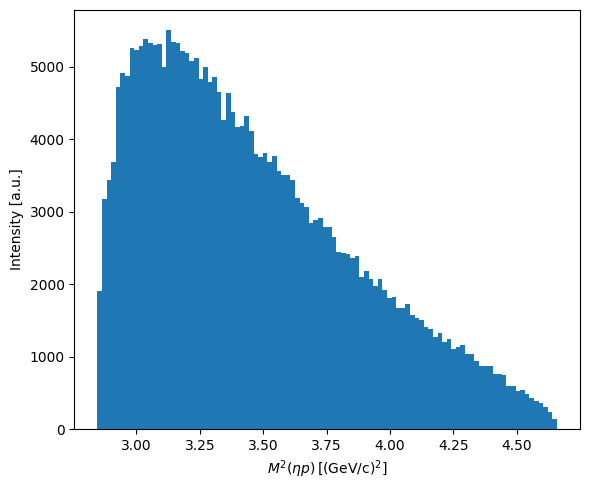

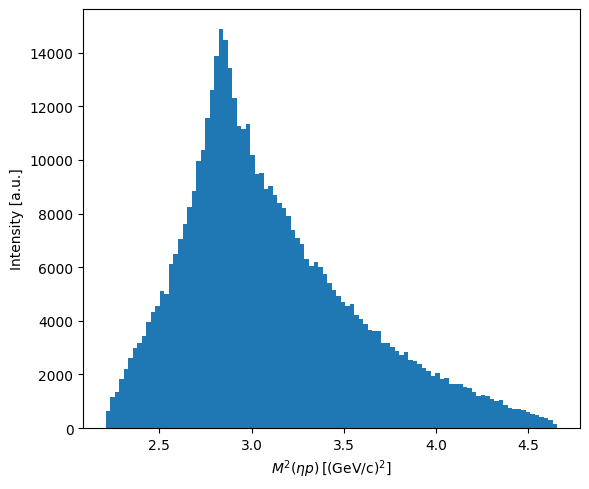

In [33]:
for i in range(n_channels):
    fig, ax = plt.subplots(figsize=(6, 5))
    intensity = np.real(INTENSITY_FUNCS_FVECTOR[i](PHSP[i]))
    c = ax.hist(
        np.real(PHSP[i]["m_01"]) ** 2,
        bins=100,
        weights=intensity,
    )
    ax.set_xlabel(R"$M^2\left(\eta p\right)\, \mathrm{[(GeV/c)^2]}$")
    ax.set_ylabel(R"Intensity [a.u.]")
    fig.tight_layout()
    plt.show()

In [34]:
DATA = []
for i in range(n_channels):
    weighted_phsp_generator = TFWeightedPhaseSpaceGenerator(
        initial_state_mass=MODELS[i].reaction_info.initial_state[-1].mass,
        final_state_masses={
            i: p.mass for i, p in MODELS[i].reaction_info.final_state.items()
        },
    )
    data_generator = IntensityDistributionGenerator(
        domain_generator=weighted_phsp_generator,
        function=INTENSITY_FUNCS_FVECTOR[i],
        domain_transformer=HELICITY_TRANSFORMERS[i],
    )
    data_momenta = data_generator.generate(50_000, rng)
    pd.DataFrame({
        (k, label): np.transpose(v)[i]
        for k, v in data_momenta.items()
        for i, label in enumerate(["E", "px", "py", "pz"])
    })
    phsp = HELICITY_TRANSFORMERS[i](phsp_momenta)
    data = HELICITY_TRANSFORMERS[i](data_momenta)
    DATA.append(data)

Generating intensity-based sample:   0%|          | 0/50000 [00:00<?, ?it/s]

2024-05-18 22:07:46.110602: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


Generating intensity-based sample:   0%|          | 0/50000 [00:00<?, ?it/s]

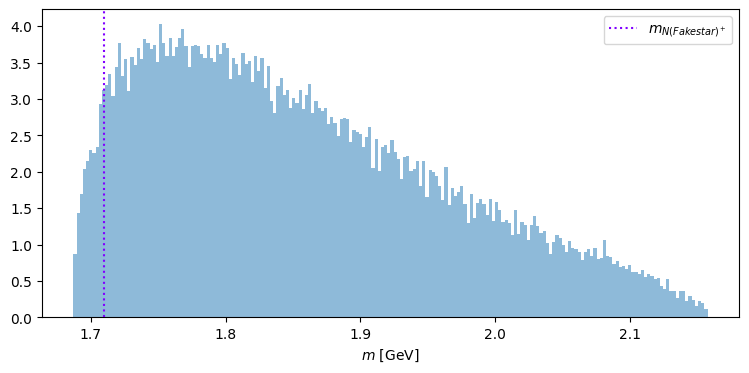

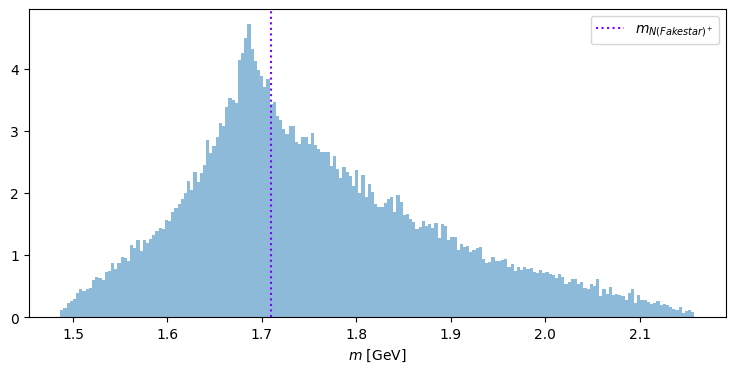

In [35]:
for i in range(n_channels):
    resonances = sorted(
        MODELS[i].reaction_info.get_intermediate_particles(),
        key=lambda p: p.mass,
    )
    evenly_spaced_interval = np.linspace(
        0, 1, len(INTENSITY_FUNCS_FVECTOR[i].parameters.items())
    )
    colors = [cm.rainbow(x) for x in evenly_spaced_interval]
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.hist(
        np.real(DATA[i]["m_01"]),
        bins=200,
        alpha=0.5,
        density=True,
    )
    ax.set_xlabel("$m$ [GeV]")
    for (k, v), color in zip(new_parameters_fvector.items(), colors):
        if k.startswith("m_{"):
            ax.axvline(
                x=v,
                linestyle="dotted",
                label=r"$" + k + "$",
                color=color,
            )
    ax.legend()
    plt.show()

## Perform fit

### Set initial parameters 

In [36]:
initial_parameters = {
    R"m_{N(Fakestar)^+}": 1.9,
    R"\beta_{N(Fakestar)^+}": 1 + 0j,
    R"g_{N(Fakestar)^+,0}": 0.8,
    R"g_{N(Fakestar)^+,1}": 0.6,
}
INTENSITY_FUNCS_FVECTOR[0].parameters


{'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+3/2} \\overline{p}_{+1/2}; N(Fakestar)^+ \\to K^{0}_{0} \\Sigma^{+}_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+1/2} \\overline{p}_{+1/2}; N(Fakestar)^+ \\to K^{0}_{0} \\Sigma^{+}_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+1/2} \\overline{p}_{-1/2}; N(Fakestar)^+ \\to K^{0}_{0} \\Sigma^{+}_{+1/2}}': (1+0j),
 'm_0': 0.547862,
 'm_1': 0.93827208816,
 'm_2': 0.93827208816,
 'm_012': 3.0969,
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+3/2} \\overline{p}_{+1/2}; N(Fakestar)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+1/2} \\overline{p}_{+1/2}; N(Fakestar)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'C_{J/\\psi(1S) \\to N(Fakestar)^+_{+1/2} \\overline{p}_{-1/2}; N(Fakestar)^+ \\to \\eta_{0} p_{+1/2}}': (1+0j),
 'm_{0,0}': 0.49761099999999997,
 'm_{1,0}': 1.1893699999999998,
 'm_{N(Fakestar)^+}': 1.71,
 'g_{N(Fakestar)^+,0}': 0.8,
 'm_{0,1}': 0.547862,
 'm_{1,1}': 0.93827208816,
 'g_{N(Fakestar)^+,1}': 0.9,
 '\\

In [37]:
def indicate_masses(ax, function):
    ax.set_xlabel("$m$ [GeV]")
    for (k, v), color_F in zip(function.parameters.items(), colors_F):
        if k.startswith("m_{N"):
            ax.axvline(
                x=v,
                linestyle="dotted",
                label=r"$" + k + "$" "(F vector)",
                color=color_F,
            )


def compare_model(
    variable_name: str,
    data: DataSample,
    phsp: DataSample,
    function: Function[DataSample, np.ndarray],
    bins: int = 100,
):
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.hist(
        data[variable_name].real,
        bins=bins,
        alpha=0.5,
        label="data",
        density=True,
    )
    intensities = function(phsp)
    ax.hist(
        phsp[variable_name].real,
        weights=intensities,
        bins=bins,
        histtype="step",
        color="red",
        label="Fit model with $F$ vector",
        density=True,
    )
    indicate_masses(ax, function)
    ax.axvline(DECAYS[0].child1.mass+DECAYS[0].child2.mass, color='grey', linestyle='dotted', label=rf'${DECAYS[0].child1.latex} \, {DECAYS[0].child2.latex}$ threshhold')
    ax.axvline(DECAYS[1].child1.mass+DECAYS[1].child2.mass, color='grey', linestyle='dotted', label=rf'${DECAYS[1].child1.latex} \, {DECAYS[1].child2.latex}$ threshhold')
    ax.legend()
    fig.show()

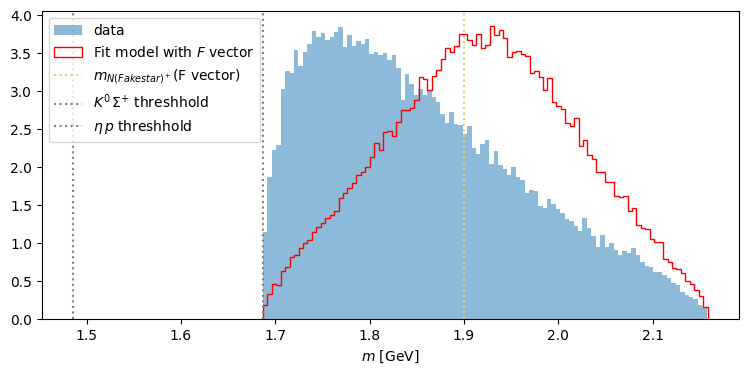

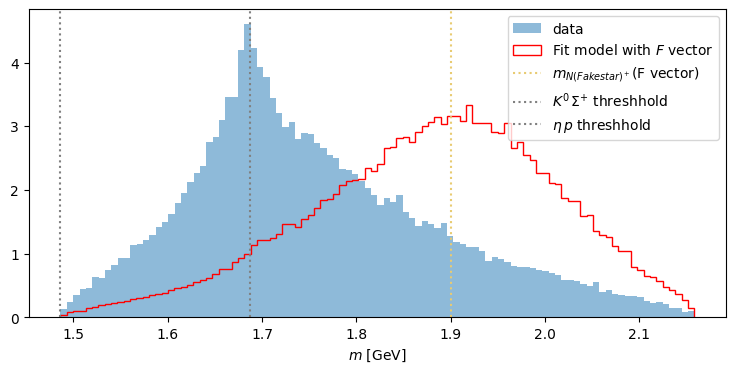

In [38]:
ORIGINAL_PARAMETERS_F = []
for i in range(n_channels):
    resonances = sorted(
        MODELS[i].reaction_info.get_intermediate_particles(),
        key=lambda p: p.mass,
    )
    evenly_spaced_interval = np.linspace(
        0, 1, len(INTENSITY_FUNCS_FVECTOR[i].parameters.items())
    )
    colors_F = [cm.rainbow(x) for x in evenly_spaced_interval]
    original_parameters = INTENSITY_FUNCS_FVECTOR[i].parameters
    ORIGINAL_PARAMETERS_F.append(original_parameters)
    INTENSITY_FUNCS_FVECTOR[i].update_parameters(initial_parameters)
    compare_model("m_01", DATA[i], PHSP[i], INTENSITY_FUNCS_FVECTOR[i])

### Define estimator

In [39]:
ESTIMATORS_F = []
for i in range(n_channels):
    estimator_fvector = UnbinnedNLL(
        INTENSITY_FUNCS_FVECTOR[i],
        data=DATA[i],
        phsp=PHSP[i],
        backend="jax",
    )
    ESTIMATORS_F.append(estimator_fvector)

In [40]:
class EstimatorSum(Estimator):
    def __init__(self, estimators: Iterable[Estimator]) -> None:
        self.__estimators = tuple(estimators)

    def __call__(self, parameters: Mapping[str, ParameterValue]) -> float:
        return sum(estimator(parameters) for estimator in self.__estimators)

    def gradient(
        self, parameters: Mapping[str, ParameterValue]
    ) -> dict[str, ParameterValue]:
        raise NotImplementedError

In [41]:
combined_estimators = EstimatorSum(ESTIMATORS_F)

## Optimized fit

In [42]:
minuit2 = Minuit2(
    callback=CSVSummary("fit_traceback.csv"),
    use_analytic_gradient=False,
)
fit_result = minuit2.optimize(combined_estimators, initial_parameters)
fit_result

0it [00:00, ?it/s]

FitResult(
 minimum_valid=True,
 execution_time=3.351858377456665,
 function_calls=162,
 estimator_value=-18694.71978168161,
 parameter_values={
  'm_{N(Fakestar)^+}': 1.7102099446837458,
  'g_{N(Fakestar)^+,0}': 0.8145358423603044,
  'g_{N(Fakestar)^+,1}': 0.8963220998212011,
  '\\beta_{N(Fakestar)^+}': (-36.888094928163476-4.678879465472437j),
 },
 parameter_errors={
  'm_{N(Fakestar)^+}': 0.000913074977897192,
  'g_{N(Fakestar)^+,0}': 0.010543626222578407,
  'g_{N(Fakestar)^+,1}': 0.0036131105694627934,
  '\\beta_{N(Fakestar)^+}': (13106208.4666789+13641374.272541337j),
 },
)

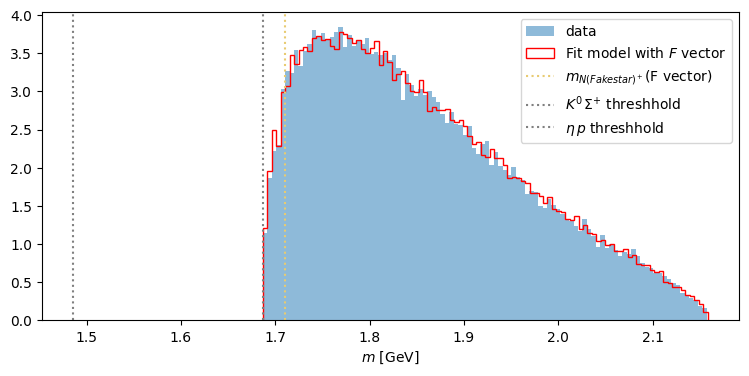

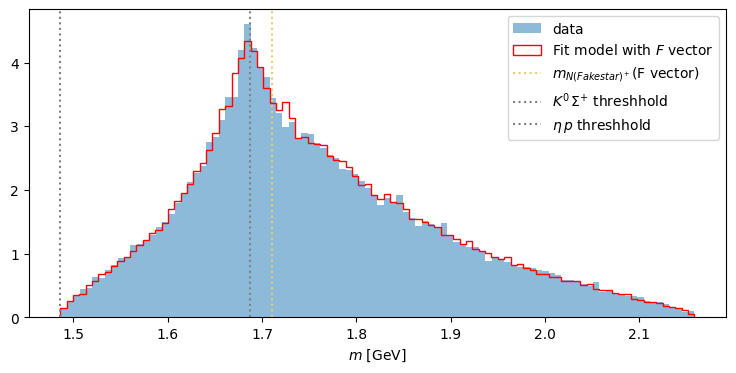

In [43]:
for i in range(n_channels):
    INTENSITY_FUNCS_FVECTOR[i].update_parameters(fit_result.parameter_values)
    compare_model("m_01", DATA[i], PHSP[i], INTENSITY_FUNCS_FVECTOR[i])

In [44]:
import pandas as pd

original_parameters = {
    **ORIGINAL_PARAMETERS_F[0],
    **ORIGINAL_PARAMETERS_F[1],
}
df = pd.DataFrame({
    f"${p}$": (
        initial_parameters[p],
        fit_result.parameter_values[p],
        original_parameters[p],
    )
    for p in fit_result.parameter_values
}).T
df.columns = ("initial", "fit result", "original")
df.round(decimals=3)

,initial,fit result,original
$m_{N(Fakestar)^+}$,1.9+0.0j,1.710+ 0.000j,1.71+0.00j
"$g_{N(Fakestar)^+,0}$",0.8+0.0j,0.815+ 0.000j,0.80+0.00j
"$g_{N(Fakestar)^+,1}$",0.6+0.0j,0.896+ 0.000j,0.90+0.00j
$\beta_{N(Fakestar)^+}$,1.0+0.0j,-36.888- 4.679j,1.00+0.00j


In [45]:
fit_result

FitResult(
 minimum_valid=True,
 execution_time=3.351858377456665,
 function_calls=162,
 estimator_value=-18694.71978168161,
 parameter_values={
  'm_{N(Fakestar)^+}': 1.7102099446837458,
  'g_{N(Fakestar)^+,0}': 0.8145358423603044,
  'g_{N(Fakestar)^+,1}': 0.8963220998212011,
  '\\beta_{N(Fakestar)^+}': (-36.888094928163476-4.678879465472437j),
 },
 parameter_errors={
  'm_{N(Fakestar)^+}': 0.000913074977897192,
  'g_{N(Fakestar)^+,0}': 0.010543626222578407,
  'g_{N(Fakestar)^+,1}': 0.0036131105694627934,
  '\\beta_{N(Fakestar)^+}': (13106208.4666789+13641374.272541337j),
 },
)

In [46]:
n_real_par = fit_result.count_number_of_parameters(complex_twice=True)
n_events = len(next(iter(data.values())))
log_likelihood = -fit_result.estimator_value
    
aic = 2 * n_real_par - 2 * log_likelihood
bic = n_real_par * np.log(n_events) - 2 * log_likelihood
aic

-37379.43956336322

In [47]:
bic

-37335.34067194117